# Using `siibra-python` to learn gene regulatory networks

`siibra-python` allows users to query gene expression data from the Allen brain atlas. [Their documentation](https://siibra-python.readthedocs.io/en/latest/examples/03_data_features/004_gene_expressions.html) provides a full explanation on how it works. 

First of all, you should determine the atlas, region and genes of interest. After that, you can use `siibra`'s `get_features` function to retrieve the desired data. The data provided comes from 6 different donors. Given a region, multiple samples from different locations are obtained for each donor. Each sample provides data from different probes (usually 4 probes). We take the average for all the probes as the value for a particular donor and location.

In [1]:
import sys
sys.path.append('/home/javier/Documents/master/tfm/neurogenpy')
import siibra
import statistics
import pandas as pd
from neurogenpy import BayesianNetwork

atlas = siibra.atlases.MULTILEVEL_HUMAN_ATLAS
region = atlas.get_region("V1")

genes = ["CREM", "ATP5G1", "RAB33B"]


samples = {gene_name: [statistics.mean(f.expression_levels) for 
                       f in siibra.get_features(region, 'gene', 
                                                gene=gene_name)] for 
           gene_name in genes}

[siibra:INFO] Version: 0.3a14
[siibra:WARNING] This is a development release. Use at your own risk.
[siibra:INFO] Please file bugs and issues at https://github.com/FZJ-INM1-BDA/siibra-python.
[siibra:INFO] No parcellation specified, using default 'Julich-Brain Cytoarchitectonic Maps 2.9'.
[siibra:INFO] Retrieving probe ids for gene CREM



    For retrieving microarray data, siibra connects to the web API of
    the Allen Brain Atlas (© 2015 Allen Institute for Brain Science),
    available from https://brain-map.org/api/index.html. Any use of the
    microarray data needs to be in accordance with their terms of use,
    as specified at https://alleninstitute.org/legal/terms-use/.
    


[siibra:INFO] Retrieving probe ids for gene ATP5G1
[siibra:INFO] Retrieving probe ids for gene RAB33B


Then, you can learn the network with the `BayesianNetwork` class after creating a `pandas DataFrame`.

       CREM    ATP5G1   RAB33B
0  5.389167  9.709525  3.81760
1  5.435017  9.666150  3.57550
2  5.475183  9.812725  3.67285
3  5.418250  9.954475  3.72965
4  5.440733  9.008950  4.49230


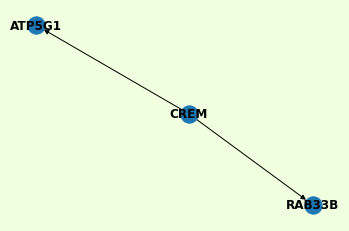

CREM {'uncond_mean': 5.433495238095238, 'cond_var': 0.04860016692970522, 'parents_coeffs': [], 'parents': []}
ATP5G1 {'uncond_mean': 9.024532142857145, 'cond_var': 0.39210540972760805, 'parents_coeffs': [-0.8244179397109443], 'parents': ['CREM']}
RAB33B {'uncond_mean': 4.281339999999999, 'cond_var': 0.6899283651657337, 'parents_coeffs': [-0.29881861893417766], 'parents': ['CREM']}


In [6]:
df = pd.DataFrame(samples)
print(df.head())

bn = BayesianNetwork().fit(df, data_type="continuous", algorithm="cl", estimation="mle")


import networkx as nx
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
nx.draw(bn.graph, with_labels=True, font_weight='bold')

ax.set_facecolor('#f0ffe0')
ax.axis('off')
fig.set_facecolor('#f0ffe0')
plt.show()

for gene, cpd in bn.get_cpds(genes).items():
    print(gene, cpd)

## Discretization of gene expression data
There are multiple ways of discretizing gene expression data. Here, we use a simple one. We use three levels (inhibition, activation and no-change). The value $x^j$ of an instance for gene $X$ is assigned to the category  $$x^{j \prime} = \begin{cases}
        \text{activation} & \text{if } \log\left(\frac{x^j}{\overline{X}}\right) > 0.2 \\
        \text{inhibition} & \text{if } \log\left(\frac{x^j}{\overline{X}}\right) < 0.2 \\
        \text{no-change} & \text{otherwise}
    \end{cases}$$

In [7]:
df = df.apply(lambda col: pd.cut(col, 
                                 bins=[-float('inf'), 2 ** (-0.2) * col.mean(),2 ** 0.2 * col.mean(), float('inf')],
                                 labels=['inh', 'no-c', 'act']))

print(df.head())

   CREM ATP5G1 RAB33B
0  no-c   no-c   no-c
1  no-c   no-c    inh
2  no-c   no-c    inh
3  no-c   no-c   no-c
4  no-c   no-c   no-c


Once data is discretized, the network can be learned the usual way:

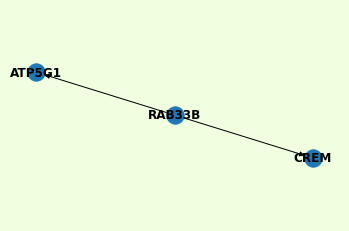

CREM
+------------+-------------+-------------+--------------+
| RAB33B     | RAB33B(act) | RAB33B(inh) | RAB33B(no-c) |
+------------+-------------+-------------+--------------+
| CREM(no-c) | 1.0         | 1.0         | 1.0          |
+------------+-------------+-------------+--------------+
ATP5G1
+--------------+---------------------+---------------------+---------------------+
| RAB33B       | RAB33B(act)         | RAB33B(inh)         | RAB33B(no-c)        |
+--------------+---------------------+---------------------+---------------------+
| ATP5G1(inh)  | 0.09615384615384616 | 0.26562500000000006 | 0.08870967741935486 |
+--------------+---------------------+---------------------+---------------------+
| ATP5G1(no-c) | 0.9038461538461539  | 0.734375            | 0.9112903225806452  |
+--------------+---------------------+---------------------+---------------------+
RAB33B
+--------------+----------+
| RAB33B(act)  | 0.216667 |
+--------------+----------+
| RAB33B(inh)  | 0.266667 

In [9]:
bn = BayesianNetwork().fit(df, data_type="discrete", algorithm="cl", estimation="bayesian")
fig, ax = plt.subplots()
nx.draw(bn.graph, with_labels=True, font_weight='bold')

ax.set_facecolor('#f0ffe0')
ax.axis('off')
fig.set_facecolor('#f0ffe0')
plt.show()

for gene, cpd in bn.get_cpds(genes).items():
    print(gene)
    print(cpd)